In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from hmmlearn import hmm
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# ファイル読み込み
in_file = '../data/avocado.csv'
df = pd.read_csv(in_file, header=0, index_col=0)

# 日付を文字列から日付型に変換
df['Date'] = pd.to_datetime(df['Date'])
df['type'] = pd.Series(np.where(df.type=='conventional', 1, 0), name='type')
df.sort_values(['Date', 'region'])

# 先頭5行表示
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,1,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,1,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,1,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,1,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,1,2015,Albany


In [3]:
# テーブルサイズ確認
df.shape

(18249, 13)

In [4]:
# 基本統計量
df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.0,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,1.0,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.0,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.0,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,1.0,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,1.0,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,1.0,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,1.0,2018.000000


In [5]:
# regionの集計
df['region'].value_counts()

Northeast              338
BuffaloRochester       338
Seattle                338
Atlanta                338
LosAngeles             338
RaleighGreensboro      338
GrandRapids            338
StLouis                338
Tampa                  338
Midsouth               338
Syracuse               338
NorthernNewEngland     338
Nashville              338
Pittsburgh             338
PhoenixTucson          338
Portland               338
CincinnatiDayton       338
Philadelphia           338
Spokane                338
Sacramento             338
BaltimoreWashington    338
MiamiFtLauderdale      338
Columbus               338
West                   338
SanFrancisco           338
Plains                 338
TotalUS                338
California             338
Chicago                338
Boise                  338
Roanoke                338
NewOrleansMobile       338
Boston                 338
NewYork                338
DallasFtWorth          338
Orlando                338
SanDiego               338
L

In [6]:
# regionラベル54個の一覧表示
for reg in set(df.region): print(reg, end=' ')

Seattle Albany Tampa StLouis GreatLakes BuffaloRochester Orlando HarrisburgScranton LasVegas Houston SanFrancisco DallasFtWorth Louisville Denver RichmondNorfolk Charlotte Southeast GrandRapids NorthernNewEngland NewYork West WestTexNewMexico Boston Chicago Plains Philadelphia Detroit CincinnatiDayton SouthCentral NewOrleansMobile SanDiego Portland TotalUS PhoenixTucson Jacksonville Syracuse Midsouth Columbus Sacramento MiamiFtLauderdale HartfordSpringfield RaleighGreensboro Atlanta LosAngeles Pittsburgh BaltimoreWashington Roanoke Spokane Indianapolis Boise SouthCarolina Nashville Northeast California 

In [7]:
# regionごとに平均値出力
df_groupby = df.groupby("region",as_index=False)
df_groupby.mean().head()

,region,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year
0,Albany,1.561036,47537.869734,1824.081775,37621.208254,162.832337,7929.747367,6647.765473,1153.496213,128.488639,1,2016.147929
1,Atlanta,1.337959,262145.322041,146116.867959,31218.510385,311.385769,84498.560888,51605.727337,32070.044556,822.786036,1,2016.147929
2,BaltimoreWashington,1.534231,398561.891479,35656.218166,245982.888876,12466.730976,104456.053462,100939.683195,2903.984586,612.382722,1,2016.147929
3,Boise,1.348136,42642.567308,20019.507604,3461.682367,3186.787840,15974.592456,13840.037249,2103.634083,30.915207,1,2016.147929
4,Boston,1.530888,287792.854527,4994.610059,214219.864290,4982.294970,63596.085207,58906.590355,4438.364704,251.124231,1,2016.147929


In [8]:
# Bostonのデータで隠れマルコフモデル
df_boston = df[df['region']=='Boston']
df_boston.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.13,450816.39,3886.27,346964.70,13952.56,86012.86,85913.60,99.26,0.0,1,2015,Boston
1,2015-12-20,1.07,489802.88,4912.37,390100.99,5887.72,88901.80,88768.47,133.33,0.0,1,2015,Boston
2,2015-12-13,1.01,549945.76,4641.02,455362.38,219.40,89722.96,89523.38,199.58,0.0,1,2015,Boston
3,2015-12-06,1.02,488679.31,5126.32,407520.22,142.99,75889.78,75666.22,223.56,0.0,1,2015,Boston
4,2015-11-29,1.19,350559.81,3609.25,272719.08,105.86,74125.62,73864.52,261.10,0.0,1,2015,Boston


In [9]:
# Dateでソート
df_boston = df_boston.sort_values('Date')
# 再インデックス
df_boston.reset_index(inplace=True, drop=True)
df_boston.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,1,2015,Boston
1,2015-01-04,1.83,2192.13,8.66,939.43,0.00,1244.04,1244.04,0.00,0.0,1,2015,Boston
2,2015-01-11,1.10,437771.89,5548.11,320577.36,121.81,111524.61,111192.88,331.73,0.0,1,2015,Boston
3,2015-01-11,1.94,2217.82,12.82,956.07,0.00,1248.93,1248.93,0.00,0.0,1,2015,Boston
4,2015-01-18,1.23,401331.33,4383.76,287778.52,132.53,109036.52,108668.74,367.78,0.0,1,2015,Boston


In [10]:
# 欠損値の確認
df_boston.isnull().any(axis=0)

Date            False
AveragePrice    False
Total Volume    False
4046            False
4225            False
4770            False
Total Bags      False
Small Bags      False
Large Bags      False
XLarge Bags     False
type            False
year            False
region          False
dtype: bool

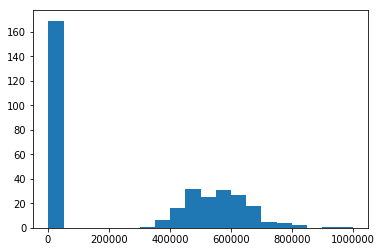

In [11]:
# Total Volumeのヒストグラム
plt.figure()
plt.hist(df_boston['Total Volume'], bins=20)
plt.show()

In [12]:
# Total Volumeを隠れマルコフモデルでモデル化
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)

In [13]:
# 推定：Xからのモデルパラメータ推定
model.fit(df_boston['Total Volume'].values.reshape(-1, 1))

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=2, n_iter=100, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [14]:
print("startprob:\n{}".format(model.startprob_))
print("transmat:\n{}".format(model.transmat_))
print("means:\n{}".format(model.means_))
print("covars:\n{}".format(model.covars_))

startprob:
[ 0.  1.]
transmat:
[[ 0.19047597  0.80952403]
 [ 0.81065063  0.18934937]]
means:
[[  14044.65012274]
 [ 561540.89233665]]
covars:
[[[  8.54028200e+07]]

 [[  1.13412421e+10]]]


In [15]:
# 復号：パラメータ既知のモデルからXを得る隠れ変数列Z
state = model.predict(df_boston['Total Volume'].values.reshape(-1, 1))
state

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0,

In [16]:
# 評価：パラメータ既知のモデルからXが得られる尤度
prob = np.exp(model.score(df_boston['Total Volume'].values.reshape(-1, 1)))
prob

0.0

In [17]:
# 適当な系列の尤度
prob = np.exp(model.score([[1000], [10000]]))
prob

1.1910590614738871e-10